# Imports

In [184]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4
from torch.utils.data import DataLoader, Dataset

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [186]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [187]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [188]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

<ipython-input-188-2dcc550019b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['matchup'] = player_df['mathcup']
<ipython-input-188-2dcc550019b0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.drop(columns=['mathcup'], inplace=True)


In [189]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [190]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [191]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [192]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

<ipython-input-192-211a0410e864>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
<ipython-input-192-211a0410e864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L


,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [193]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [194]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [195]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [196]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [197]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [198]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


## News Data


In [199]:
news_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/playernews_final_updated_2024.xlsx'
news_df = pd.read_excel(news_data_url)

In [200]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url']
news_df.drop(columns=columns_to_remove, inplace=True)

# Convert 'time_interval' to datetime
news_df['date'] = pd.to_datetime(news_df['time_interval'], errors='coerce')

# Checking the converted dates and if there are any parsing errors or null values
news_df[['time_interval', 'date']].head(), news_df['date'].isnull().sum()

(  time_interval       date
 0    06/13/2023 2023-06-13
 1    06/13/2023 2023-06-13
 2    06/13/2023 2023-06-13
 3    06/12/2023 2023-06-12
 4    06/12/2023 2023-06-12,
 0)

### Merging

In [201]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [202]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [203]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [204]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [205]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [206]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.25: EXPERIMENTAL REMOVING OF MORE COLUMNS TO SIMPLIFY THE MODEL

In [207]:
# EXPERIMENTAL:
more_columns_to_remove = \
 ['opp_team', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
  'fta', 'ftpercent', 'pfo', 'plusminus', 'matchup', 'is_home', 'date', 'min',
  'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm', 'team_3pa',
  'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent', 'team_oreb',
  'team_dreb', 'team_reb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
  'team_pfidk', 'team_plusminus', 'opp_pts', 'opp_fgm', 'opp_fga',
  'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent', 'opp_ftm', 'opp_fta',
  'opp_ftpercent', 'opp_oreb', 'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl',
  'opp_blk', 'opp_tov', 'opp_pfidk', 'opp_plusminus']
# df.drop(columns=more_columns_to_remove, inplace=True)

In [208]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

In [209]:
# Create a boolean mask
mask = (df == '-')

# Use `any` to check each column
columns_with_dash = mask.any(axis=0)

# Print the columns that contain '-'
print(columns_with_dash[columns_with_dash].index.tolist())

# Convert specific columns to strings
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(str)

# Replace '-' with '0'
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].replace('-', '0')

# Convert these columns back to floats
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(float)


['fgpercent', '3ppercent', 'ftpercent']


## 1.275: EXPERIMENTAL REMOVING OF PLAYERS THAT HAVENT PLAYED 10 GAMES AND THAT ARE NOT IN TOP 150

In [210]:
# Filter out players who have played less than 10 games
game_counts = df['player'].value_counts()
players_at_least_10_games = game_counts[game_counts >= 10].index
filtered_df = df[df['player'].isin(players_at_least_10_games)]

# Compute season average fantasy points for each player
season_averages = filtered_df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)

# Keep only the top 150 players in terms of season average
top_players = season_averages.head(150)['player']
simple_df = filtered_df[filtered_df['player'].isin(top_players)]

In [211]:
simple_df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
6,Jayson Tatum,BOS,WAS,2024-03-17,145,1,27,30,8,17,...,10,30,40,24,3,5,16,20,-26,36.0
7,Jrue Holiday,BOS,WAS,2024-03-17,145,1,22,7,3,7,...,10,30,40,24,3,5,16,20,-26,11.0
8,Al Horford,BOS,WAS,2024-03-17,145,1,23,14,5,7,...,10,30,40,24,3,5,16,20,-26,13.0
14,Jordan Poole,WAS,BOS,2024-03-17,145,0,23,31,12,19,...,12,31,43,30,9,6,15,17,26,22.0
21,Luka Doncic,DAL,DEN,2024-03-17,145,1,40,37,12,27,...,6,31,37,26,7,6,8,16,-2,36.0


1.29. ADDING MORE FEATURES FOR DEBUGGING

In [212]:
players_list = list(df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)['player'])
players_dict = {players_list[i]: i for i in range(len(players_list))}
players_inv_dict = {i: players_list[i] for i in range(len(players_list))}

In [213]:
int(str(df.iloc[132]['gamedate'])[-14:-12]) * 1000 + int(str(df.iloc[132]['gamedate'])[-11:-9])

3017

In [214]:
def intify_player(player):
    return players_dict[player] / 1000

def intify_gamedate(gamedate):
    return (int(str(gamedate)[-14:-12]) * 1000 + int(str(gamedate)[-11:-9])) / 100000

In [215]:
df['int_player'] = df['player'].apply(intify_player)
df['int_gamedate'] = df['gamedate'].apply(intify_gamedate)

In [216]:
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp,int_player,int_gamedate
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,40,24,3,5,16,20,-26,28.0,0.230,0.03017
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,40,24,3,5,16,20,-26,13.0,0.455,0.03017
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,40,24,3,5,16,20,-26,17.0,0.263,0.03017
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,40,24,3,5,16,20,-26,29.0,0.240,0.03017
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,40,24,3,5,16,20,-26,1.0,0.295,0.03017


## 1.3 One-Hot Encoding

In [217]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team', 'team'])

In [219]:
## reorder the columns for visual purposes
columns_order = ['player', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [220]:
df.head()

,player,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,3pm,...,team_ORL,team_PHI,team_PHX,team_POR,team_SAC,team_SAS,team_TOR,team_UTA,team_WAS,fp
0,Payton Pritchard,2024-03-17,145,1,35,14,6,15,40.0,2,...,False,False,False,False,False,False,False,False,False,28.0
1,Svi Mykhailiuk,2024-03-17,145,1,23,9,3,7,42.9,3,...,False,False,False,False,False,False,False,False,False,13.0
2,Luke Kornet,2024-03-17,145,1,20,14,5,9,55.6,0,...,False,False,False,False,False,False,False,False,False,17.0
3,Sam Hauser,2024-03-17,145,1,23,30,10,13,76.9,10,...,False,False,False,False,False,False,False,False,False,29.0
4,Neemias Queta,2024-03-17,145,1,8,0,0,0,0.0,0,...,False,False,False,False,False,False,False,False,False,1.0


In [221]:
for col in df.columns:
  print(col)

player
gamedate
days_since
winloss
minuters
pts
fgm
fga
fgpercent
3pm
3pa
3ppercent
ftm
fta
ftpercent
oreb
dreb
reb
ast
stl
blk
tov
pfo
plusminus
matchup
is_home
game_id
date
min
team_pts
team_fgm
team_fga
team_fgpercent
team_3pm
team_3pa
team_3ppercent
team_ftm
team_fta
team_ftpercent
team_oreb
team_dreb
team_reb
team_ast
team_stl
team_blk
team_tov
team_pfidk
team_plusminus
opp_pts
opp_fgm
opp_fga
opp_fgpercent
opp_3pm
opp_3pa
opp_3ppercent
opp_ftm
opp_fta
opp_ftpercent
opp_oreb
opp_dreb
opp_reb
opp_ast
opp_stl
opp_blk
opp_tov
opp_pfidk
opp_plusminus
int_player
int_gamedate
opp_team_ATL
opp_team_BKN
opp_team_BOS
opp_team_CHA
opp_team_CHI
opp_team_CLE
opp_team_DAL
opp_team_DEN
opp_team_DET
opp_team_GSW
opp_team_HOU
opp_team_IND
opp_team_LAC
opp_team_LAL
opp_team_MEM
opp_team_MIA
opp_team_MIL
opp_team_MIN
opp_team_NOP
opp_team_NYK
opp_team_OKC
opp_team_ORL
opp_team_PHI
opp_team_PHX
opp_team_POR
opp_team_SAC
opp_team_SAS
opp_team_TOR
opp_team_UTA
opp_team_WAS
team_ATL
team_BKN
team_BOS
t

## 1.4 Split per player



In [180]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler

class NBAFantasyDataset(Dataset):
    def __init__(self, dataframe, news_df, game_look_back=10, news_look_back=14):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the fantasy data.
            news_dataframe (pandas.DataFrame): The dataframe containing the news data.
            look_back (int): Number of past games to consider for each sample.
        """
        self.dataframe = dataframe
        self.look_back = game_look_back

        # Prepare the news data
        self.news_dataframe = news_df
        self._prepare_news_data()

        # Prepare player games indices
        self.player_game_indices = self._get_player_game_indices()

        # Normalize features
        self.scaler = StandardScaler()
        self._normalize_features()

    def _prepare_news_data(self):
        # Convert news date to datetime format
        self.news_dataframe['date'] = pd.to_datetime(self.news_dataframe['time_interval'], errors='coerce')
        self.news_dataframe = self.news_dataframe.drop(columns=['time_interval'])
        # Assume `player_name` in news_dataframe aligns with `player` in dataframe
        self.news_dataframe.rename(columns={'player_name': 'player'}, inplace=True)

    def _get_player_game_indices(self):
        """Get a list of tuples indicating the start and end indices of each player's games."""
        player_game_indices = []
        players = self.dataframe['player'].unique()
        for player in players:
            player_data = self.dataframe[self.dataframe['player'] == player]
            for i in range(self.look_back, len(player_data)):
                start_index = player_data.index[i-self.look_back]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player', 'gamedate', 'game_id', 'fp'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)

    def _get_news_for_player(self, player, date):
        """Retrieve news for the last 14 days for the specified player."""
        end_date = date
        start_date = end_date - pd.Timedelta(days=news_look_back)
        mask = (self.news_dataframe['player'] == player) & (self.news_dataframe['date'] >= start_date) & (self.news_dataframe['date'] <= end_date)
        news_items = self.news_dataframe.loc[mask,'title', 'short', 'long'].tolist()  # You could also include other fields
        return ' '.join(news_items)

    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        player = self.dataframe.iloc[end_index]['player']
        gamedate = self.dataframe.iloc[end_index]['gamedate']

        features = player_data.drop(columns=['player', 'gamedate', 'game_id', 'fp']).values
        target = self.dataframe.iloc[end_index]['fp']

        news_features = self._get_news_for_player(player, gamedate)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32), news_features

In [225]:
class OldDataset(Dataset):
    def __init__(self, dataframe, look_back=10):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the data.
        """
        self.dataframe = dataframe
        # player + game_date logic:
        self.player_game_indices = self._get_player_game_indices()
        # for normalization:
        self.scaler = StandardScaler()
        self._normalize_features()
        # for "last 10 game" approach:
        self.look_back = look_back

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player','gamedate', 'game_id', 'fp', 'int_player', 'int_gamedate', 'date', 'matchup'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)

    def _get_player_game_indices(self):
        """Get a list of tuples indicating the start and end indices of each player's games."""
        player_game_indices = []
        players = self.dataframe['player'].unique()
        count = 0
        for player in players:
            count += 1
            player_data = self.dataframe[self.dataframe['player'] == player]
            #player_data = player_data.sort_values(by='days_since').reset_index(drop=True) # im not sure
            for i in range(10, len(player_data)):
                start_index = player_data.index[i-10]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        features = player_data.drop(columns=['player','gamedate', 'game_id', 'fp', 'matchup', 'date']).values
        # features = features.replace('-', 0).astype(float)
        target = self.dataframe.iloc[end_index]['fp']
        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [181]:
sorted_df = df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True)
print(sorted_df.columns)


Index(['player', 'gamedate', 'days_since', 'winloss', 'minuters', 'pts', 'fgm',
       'fga', 'fgpercent', '3pm',
       ...
       'team_OKC', 'team_ORL', 'team_PHI', 'team_PHX', 'team_POR', 'team_SAC',
       'team_SAS', 'team_TOR', 'team_UTA', 'team_WAS'],
      dtype='object', length=128)


In [182]:
def collate_fn(batch):
    """
    Custom collate function for handling variable-length sequences.
    """
    features, targets, news = zip(*batch)
    # Pad the sequences to the maximum length in the batch

    features_padded = nn.utils.rnn.pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    news_collated = list(news)

    return features_padded, targets, news_collated

New

In [ ]:
# Create a DataLoader
batch_size = 32 # Adjust the batch size as needed # 2 was bad # idt 32 changed anything too
dataset2 = NBAFantasyDataset(sorted_df, news_df)
dataloader2 = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

Old

In [226]:
sdf = df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True)

def collate_old(batch):
    """
    Custom collate function for handling variable-length sequences.
    """
    features, targets = zip(*batch)
    # Pad the sequences to the maximum length in the batch
    features_padded = nn.utils.rnn.pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    return features_padded, targets

batch_size = 32 # Adjust the batch size as needed # 2 was bad # idt 32 changed anything too
dataset = OldDataset(df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_old)


In [223]:
print(df.columns)
print(simple_df.columns)

Index(['player', 'gamedate', 'days_since', 'winloss', 'minuters', 'pts', 'fgm',
       'fga', 'fgpercent', '3pm',
       ...
       'team_ORL', 'team_PHI', 'team_PHX', 'team_POR', 'team_SAC', 'team_SAS',
       'team_TOR', 'team_UTA', 'team_WAS', 'fp'],
      dtype='object', length=130)
Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 

In [227]:
len(simple_df)

8384

## 1.5 Train-Test Split

In [228]:
from torch.utils.data import random_split

# Define the split sizes
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [232]:
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader_old = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_old, num_workers=2)
test_dataloader_old = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_old, num_workers=2)

## 1.6 Data Analysis

In [123]:
len(dataloader)

519

In [124]:
len(dataset)

16589

In [125]:
from tqdm import tqdm

counter = 0
C = 200
epochs = 0
players_in_dataloader = []
for epoch in range(epochs):
    for features, targets in tqdm(dataloader):
        for idx in range(len(features)):
            for idx2 in range(len(features[0])):
                player_idx = int(np.round(features[idx][idx2][11].item() * 1000))
                players_in_dataloader.append((players_inv_dict[player_idx]))
        """
        for i in range(len(features[0])):
            date = int(np.round(features[idx][i][12].item() * 100000))
            month = date // 1000
            day = date % 1000
            print("Month: ", month, " . Day: ", day)
        print("Actual fantasy points:", targets[0].item())
        """
        counter += 1
print(len(set(players_in_dataloader)))

0


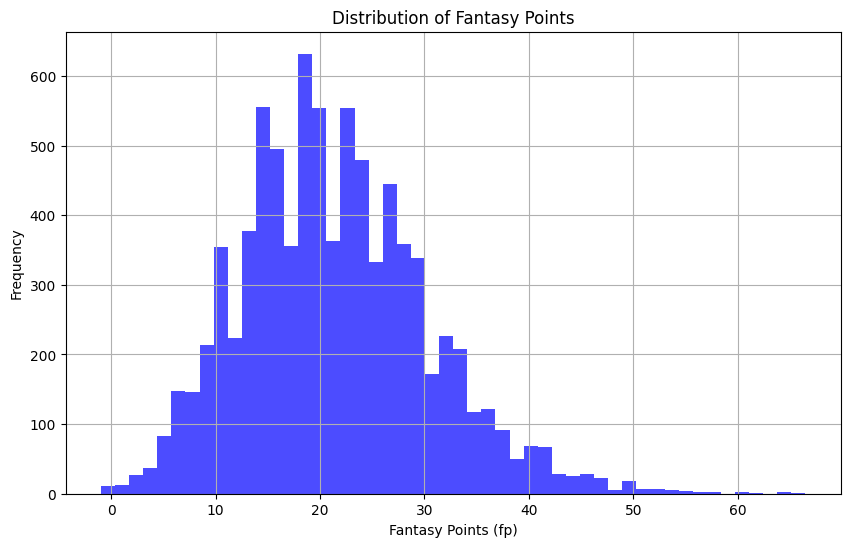

In [126]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'fp' is the column with fantasy points
plt.figure(figsize=(10, 6))
plt.hist(simple_df['fp'], bins=50, alpha=0.7, color='blue')
plt.xlabel('Fantasy Points (fp)')
plt.ylabel('Frequency')
plt.title('Distribution of Fantasy Points')
plt.grid(True)
plt.show()

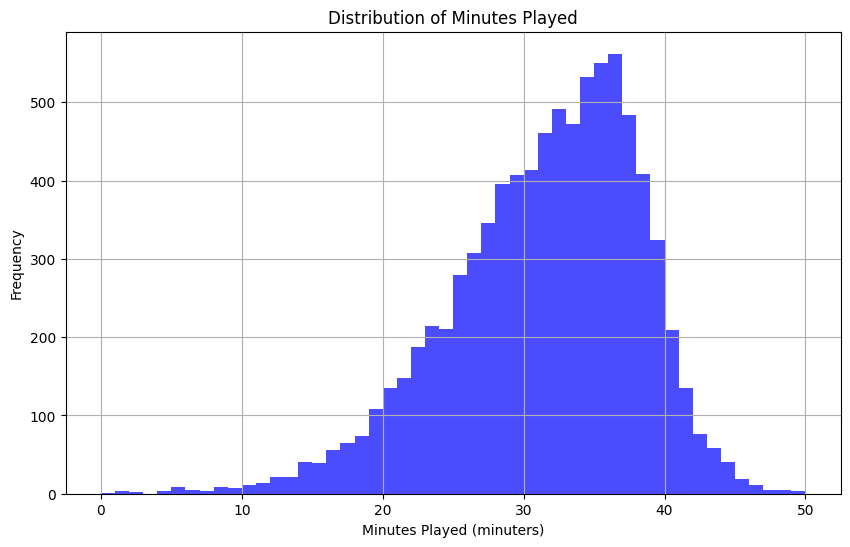

In [127]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'fp' is the column with fantasy points
plt.figure(figsize=(10, 6))
plt.hist(simple_df['minuters'], bins=50, alpha=0.7, color='blue')
plt.xlabel('Minutes Played (minuters)')
plt.ylabel('Frequency')
plt.title('Distribution of Minutes Played')
plt.grid(True)
plt.show()

In [128]:
print("Top 150 players mean fp:", np.mean(simple_df['fp']), " and median fp:", np.median(simple_df['fp']))

Top 150 players mean fp: 21.389014790076335  and median fp: 20.5


## 2.1 Baseline model building



In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [130]:
class CNNEncoder(nn.Module):
    def __init__(self, embedding_layer, num_filters, filter_sizes):
        super().__init__()
        self.embedding = embedding_layer
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_layer.embedding_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)  # [Batch, Sequence, Embedding]
        x = x.unsqueeze(1)  # [Batch, 1, Sequence, Embedding]
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        return x

class LSTM(nn.Module):
    def __init__(self, embedding_layer, num_filters, filter_sizes, hidden_dim, num_layers=1, additional_features_dim):
        super(BaselineLSTM, self).__init__()
        self.encoder = CNNEncoder(embedding_layer, num_filters, filter_sizes)
        self.lstm = nn.LSTM(num_filters * len(filter_sizes) + additional_features_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        output, (h_n, c_n) = self.lstm(x)
        # Take the output of the last time step
        output = self.fc(h_n[-1])
        return output



SyntaxError: non-default argument follows default argument (<ipython-input-130-14c0901272e9>, line 20)

In [229]:
# Old Model


class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BaselineLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        output, (h_n, c_n) = self.lstm(x)
        # Take the output of the last time step
        output = self.fc(h_n[-1])
        return output



In [233]:
from tqdm import tqdm

def train(model, dataloader, epochs, learning_rate, device, grad_clip=None):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, targets in tqdm(dataloader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}')

# Example usage
input_size = dataset[0][0].shape[1]  # Number of features
hidden_size = 64  # Adjust the size of the hidden layer as needed
output_size = 1  # We're predicting a single value (fantasy points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_model = BaselineLSTM(input_size, hidden_size, output_size)
train(lstm_model, train_dataloader_old, epochs=20, learning_rate=0.001, device=device, grad_clip=1.0)
torch.save(lstm_model.state_dict(), "lstm_model.pth")

cuda


  0%|          | 0/415 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 414/415 [00:47<00:00,  7.94it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 415/415 [00:47<00:00,  8.76it/s]


Epoch 1/20, Loss: 98.60342223845332


100%|██████████| 415/415 [00:47<00:00,  8.80it/s]


Epoch 2/20, Loss: 46.46099136076778


100%|██████████| 415/415 [00:49<00:00,  8.40it/s]


Epoch 3/20, Loss: 43.70381656784609


100%|██████████| 415/415 [00:47<00:00,  8.65it/s]


Epoch 4/20, Loss: 41.88796894579048


100%|██████████| 415/415 [00:47<00:00,  8.73it/s]


Epoch 5/20, Loss: 40.10929209927478


100%|██████████| 415/415 [00:47<00:00,  8.82it/s]


Epoch 6/20, Loss: 38.58605105388595


100%|██████████| 415/415 [00:47<00:00,  8.68it/s]


Epoch 7/20, Loss: 36.70582829900535


100%|██████████| 415/415 [00:46<00:00,  9.01it/s]


Epoch 8/20, Loss: 34.818535859900784


100%|██████████| 415/415 [00:47<00:00,  8.73it/s]


Epoch 9/20, Loss: 33.05652035862566


100%|██████████| 415/415 [00:47<00:00,  8.76it/s]


Epoch 10/20, Loss: 31.186792980331973


100%|██████████| 415/415 [00:46<00:00,  8.99it/s]


Epoch 11/20, Loss: 29.436195012747522


100%|██████████| 415/415 [00:47<00:00,  8.74it/s]


Epoch 12/20, Loss: 27.671498755949088


100%|██████████| 415/415 [00:46<00:00,  8.93it/s]


Epoch 13/20, Loss: 25.86114563539804


100%|██████████| 415/415 [00:46<00:00,  8.84it/s]


Epoch 14/20, Loss: 24.274634177426258


100%|██████████| 415/415 [00:48<00:00,  8.64it/s]


Epoch 15/20, Loss: 22.70797934015113


100%|██████████| 415/415 [00:46<00:00,  8.93it/s]


Epoch 16/20, Loss: 21.307044016596784


100%|██████████| 415/415 [00:47<00:00,  8.82it/s]


Epoch 17/20, Loss: 19.81890445387507


100%|██████████| 415/415 [00:47<00:00,  8.81it/s]


Epoch 18/20, Loss: 18.577179138918957


100%|██████████| 415/415 [00:46<00:00,  8.96it/s]


Epoch 19/20, Loss: 17.387693559118063


100%|██████████| 415/415 [00:47<00:00,  8.77it/s]

Epoch 20/20, Loss: 16.31489641810038


In [ ]:
len(train_dataset)

## 2.2 Training the Model

In [235]:
from tqdm import tqdm

def train(model, dataloader, epochs, learning_rate, device, grad_clip=None):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, targets in tqdm(dataloader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}')

# Example usage
input_size = dataset[0][0].shape[1]  # Number of features
hidden_size = 64  # Adjust the size of the hidden layer as needed
output_size = 1  # We're predicting a single value (fantasy points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_model = BaselineLSTM(input_size, hidden_size, output_size)
train(lstm_model, train_dataloader, epochs=20, learning_rate=0.001, device=device, grad_clip=1.0)
torch.save(lstm_model.state_dict(), "lstm_model.pth")

cuda


  0%|          | 0/415 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/415 [00:00<?, ?it/s]


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "<ipython-input-182-f4c25adf6bad>", line 5, in collate_fn
    features, targets, news = zip(*batch)
ValueError: not enough values to unpack (expected 3, got 2)


In [ ]:
torch.save(lstm_model.state_dict(), "lstm_model.pth")

## Testing the Model

  4%|▍         | 16/415 [00:02<00:48,  8.30it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c384a3bc550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c384a3bc550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdow

Accuracy (within ±5 FP): 17.36%
Mean Squared Error Loss: 306.5724


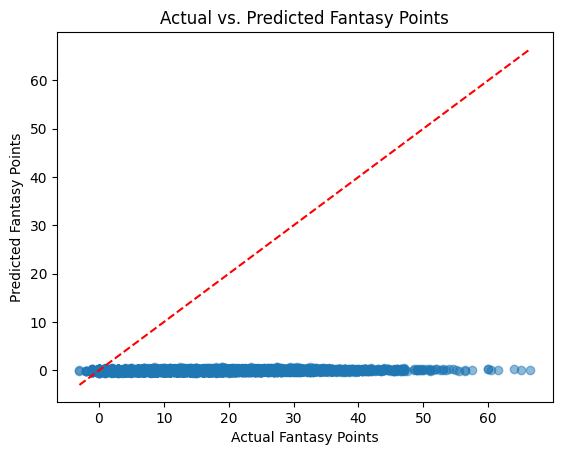

(0.17361163439077687, 306.5723527655544)

In [237]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, threshold, device):
    model.to(device)
    model.eval()
    total_hits = 0
    total_samples = 0
    total_mse_loss = 0
    criterion = nn.MSELoss()
    actual_fps = []
    predicted_fps = []

    with torch.no_grad():
        for features, targets in tqdm(dataloader):
            features, targets = features.to(device), targets.to(device)
            outputs = model(features).squeeze()
            mse_loss = criterion(outputs, targets)
            total_mse_loss += mse_loss.item()
            hits = torch.abs(outputs - targets) <= threshold
            total_hits += hits.sum().item()
            total_samples += targets.size(0)
            actual_fps.extend(targets.cpu().numpy())
            predicted_fps.extend(outputs.cpu().numpy())

    accuracy_rate = total_hits / total_samples
    average_mse_loss = total_mse_loss / len(dataloader)
    print(f'Accuracy (within ±{threshold} FP): {accuracy_rate * 100:.2f}%')
    print(f'Mean Squared Error Loss: {average_mse_loss:.4f}')

    # Plot actual vs. predicted fantasy points
    plt.scatter(actual_fps, predicted_fps, alpha=0.5)
    plt.xlabel('Actual Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')
    plt.title('Actual vs. Predicted Fantasy Points')
    plt.plot([min(actual_fps), max(actual_fps)], [min(actual_fps), max(actual_fps)], 'r--')  # Diagonal line for reference
    plt.show()

    return accuracy_rate, average_mse_loss

# Example usage
threshold = 5  # Define your threshold value
evaluate_model(lstm_model, train_dataloader_old, threshold, device)


In [ ]:
threshold = 5  # Define your threshold value
evaluate_model(lstm_model, train_dataloader, threshold, device)


## Enriched LSTM?

In [ ]:
class EnrichedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5, bidirectional=False):
        super(EnrichedLSTM, self).__init__()
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        lstm_out, (h_n, c_n) = self.lstm(x)
        if self.num_directions == 2:
            # Concatenate the hidden states from both directions
            h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_n = h_n[-1]

        # Apply dropout
        h_n = self.dropout(h_n)

        # Fully connected layer
        output = self.fc(h_n)
        return output

In [ ]:
# Example usage
input_size = dataset[0][0].shape[1]  # Number of features
hidden_size = 64  # Adjust the size of the hidden layer as needed
output_size = 1  # We're predicting a single value (fantasy points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_model_2 = EnrichedLSTM(input_size, hidden_size, output_size, num_layers=2)
train(lstm_model_2, train_dataloader, epochs=20, learning_rate=0.001, device=device, grad_clip=1.0)
torch.save(lstm_model_2.state_dict(), "lstm_model_2.pth")

In [ ]:
# Example usage
threshold = 5  # Define your threshold value
evaluate_model(lstm_model_2, test_dataloader, threshold, device)

In [ ]:
# Example usage
threshold = 5  # Define your threshold value
evaluate_model(lstm_model_2, train_dataloader, threshold, device)

In [ ]:
hyperparams = {
    'num_layers': [1, 2, 3],
    'hidden_size': [32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [10, 20, 30]
}

In [ ]:
import itertools
import torch

def grid_search(hyperparams, device):
    best_loss = float('inf')
    best_params = {}

    # Create all combinations of hyperparameters
    for num_layers, hidden_size, dropout_rate, learning_rate, num_epochs in itertools.product(
        hyperparams['num_layers'],
        hyperparams['hidden_size'],
        hyperparams['dropout_rate'],
        hyperparams['learning_rate'],
        hyperparams['num_epochs']):

        # Initialize the model with current set of hyperparameters
        model = EnrichedLSTM(input_size=dataset[0][0].shape[1],  # Number of features
                             hidden_size=hidden_size,
                             output_size=1,  # Assuming output is always 1
                             num_layers=num_layers,
                             dropout_rate=dropout_rate,
                             bidirectional=False)  # Assuming no bidirectional in the current setup

        # Train the model
        train(model, train_dataloader, num_epochs, learning_rate, device)

        # Evaluate the model
        _, loss = evaluate_model(model, test_dataloader, 5, device)  # assuming a threshold of 5 for accuracy

        # Check if the current model is better
        if loss < best_loss:
            best_loss = loss
            best_params = {
                'num_layers': num_layers,
                'hidden_size': hidden_size,
                'dropout_rate': dropout_rate,
                'learning_rate': learning_rate,
                'num_epochs': num_epochs
            }
            print(f"New best model with loss {best_loss} using {best_params}")

    return best_params

In [ ]:
# Assuming you have defined train_dataloader and val_dataloader
best_hyperparameters = grid_search(
    hyperparams,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Best hyperparameters found:", best_hyperparameters)

## Decision Tree Baseline

In [ ]:
class NBAFantasyDatasetTree(Dataset):
    def __init__(self, dataframe, look_back=10):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the data.
        """
        self.dataframe = dataframe
        # player + game_date logic:
        self.player_game_indices = self._get_player_game_indices()
        # for normalization:
        self.scaler = StandardScaler()
        self._normalize_features()
        # for "last 10 game" approach:
        self.look_back = look_back

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'int_player', 'int_gamedate', 'date', 'matchup'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)

    def _get_player_game_indices(self):
        """Get a list of tuples indicating the start and end indices of each player's games."""
        player_game_indices = []
        players = self.dataframe['player'].unique()
        count = 0
        for player in players:
            count += 1
            player_data = self.dataframe[self.dataframe['player'] == player]
            #player_data = player_data.sort_values(by='days_since').reset_index(drop=True) # im not sure
            for i in range(10, len(player_data)):
                start_index = player_data.index[i-10]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        # Flatten the last 10 games' features into one long vector
        flattened_features = player_data.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'matchup', 'date']).values.flatten()
        target = self.dataframe.iloc[end_index]['fp']
        return torch.tensor(flattened_features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)



In [ ]:
# Create DataLoader for the dataset
dataset = NBAFantasyDatasetTree(df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Batch size of 1 since we're treating each sample independently

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data for training
X_train = [features.numpy() for features, _ in train_dataloader]
y_train = [target.numpy() for _, target in train_dataloader]

# Flatten the list of arrays into a single array
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

# Define and train the Decision Tree model
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

print("Training complete.")

In [ ]:
def evaluate_model(model, dataloader, threshold):
    # Prepare the data for evaluation
    X_test = [features.numpy() for features, _ in dataloader]
    y_test = [target.numpy() for _, target in dataloader]

    # Flatten the list of arrays into a single array
    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Predict using the trained model
    predictions = model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    # Calculate accuracy based on the threshold
    accuracy = np.mean(np.abs(predictions - y_test) <= threshold)
    print(f'Accuracy (within ±{threshold} FP): {accuracy * 100:.2f}%')

    # Optionally plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Line for perfect predictions
    plt.xlabel('Actual Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')
    plt.title('Actual vs. Predicted Fantasy Points')
    plt.show()

    return mse, accuracy

# Example usage
threshold = 5  # Define your threshold for accuracy
evaluate_model(dt_model, test_dataloader, threshold)

In [ ]:
# Example usage
threshold = 5  # Define your threshold for accuracy
evaluate_model(dt_model, train_dataloader, threshold)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # More estimators might improve performance

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model using the existing evaluation function
evaluate_model(rf_model, test_dataloader, threshold=5)

In [ ]:
# Evaluate the model using the existing evaluation function
evaluate_model(rf_model, train_dataloader, threshold=5)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

# # Evaluate the best model
# best_rf = grid_search.best_estimator_
# evaluate_model(best_rf, test_dataloader, threshold=5)